# 1. Setup

### Import dependecies

In [1]:
import cv2
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import uuid

In [2]:
# import Tensorflow functional API

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

### Set GPU growth

In [3]:
# Avoid out of memory error by setting GPU memory consumption growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

### Create folder structure 

In [4]:
POSITIVE_PATH = os.path.join('data', 'positive')
NEGATIVE_PATH = os.path.join('data', 'negative')
ANCHOR_PATH = os.path.join('data', 'anchor')

# creating directories

# os.makedirs(POSITIVE_PATH)
# os.makedirs(NEGATIVE_PATH)
# os.makedirs(ANCHOR_PATH)

# 2. Collect images

### Untar labelled faces in the wild dataset

In [5]:
# uncompress tar gz file
# !tar -xf lfw.tgz

In [6]:
# move LFW images tothe following repository data/negative

for directory in os.listdir('lfw'):
    file_path = os.path.join('lfw', directory)
    for file in os.listdir(file_path):
        EXISING_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEGATIVE_PATH, file)
        os.replace(EXISING_PATH, NEW_PATH)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'lfw'

### Collect Positive and anchor images

In [ ]:
# establishing a connection to webcam

cap = cv2.VideoCapture(0)

while cap.isOpened():
    
    ret, frame = cap.read()
    
    # cut down frame to 250px*250px
    frame = frame[120:120+250, 200:200+250,:]
    
    # collect anchor images
    if cv2.waitKey(1) & 0XFF == ord('a'):
        
        image_name = os.path.join(ANCHOR_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(image_name,frame)
    
    # collect positive images
    if cv2.waitKey(1) & 0XFF == ord('p'):
        
        image_name = os.path.join(POSITIVE_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(image_name,frame)
    
    
    # show image back to screen
    cv2.imshow('Image Collection', frame)
    
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()

In [ ]:
plt.imshow(frame)

# 3. Load Preprocess images

### Get image directories

In [5]:
# To create a dataset of all files matching a pattern, use tf.data.Dataset.list_files:

anchor = tf.data.Dataset.list_files(ANCHOR_PATH + '\*.jpg').take(501)
positive = tf.data.Dataset.list_files(POSITIVE_PATH + '\*.jpg').take(501)
negative = tf.data.Dataset.list_files(NEGATIVE_PATH + '\*.jpg').take(501)

In [6]:
dir_test = anchor.as_numpy_iterator()

In [7]:
dir_test.next()

b'data\\anchor\\57e92465-343a-11ed-82c1-c8b29b0ea9b0.jpg'

### Preprocessing: Scale and Resize

In [8]:
def preprocess(file_path):
    
    """
        In this function, we first read in the image and then load the image.
        After this we resize the image into 100px * 100px * 3 color channels.
        Last line helps in scaling.
    """
    byte_image = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_image)  # loading of image
    img = tf.image.resize(img, (100,100))
    img = img/255.0
    
    return img

### Create labelled dataset

In [9]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [10]:
samples = data.as_numpy_iterator()

In [11]:
example = samples.next()

### Build train and test partition

In [12]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [13]:
res = preprocess_twin(*example)

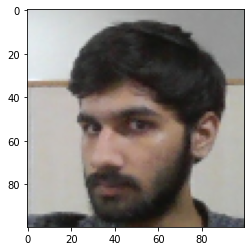

In [14]:
plt.imshow(res[0])

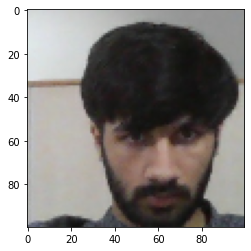

In [15]:
plt.imshow(res[1])

In [16]:
res[2]

1.0

In [17]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [18]:
data_samples = data.as_numpy_iterator()

In [19]:
s = data_samples.next()

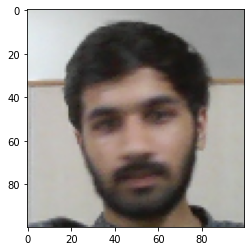

In [20]:
plt.imshow(s[0])

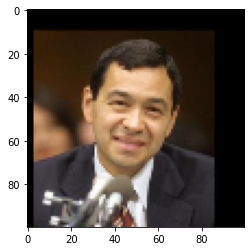

In [21]:
plt.imshow(s[1])

In [22]:
s[2]

0.0

In [23]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [24]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Model Engineering

### Build embedding layers

In [25]:
def make_embedding():
    inp = Input(shape = (100,100,3),name ='input_image')
    
    # First block of model
    
    # we are passing inp as a connecting layer. This is a part of Tensorflow functional API
    c1 = Conv2D(64,(10,10),activation = 'relu')(inp) 
    m1 = MaxPooling2D(64,(2,2), padding = 'same')(c1)
    
    # Second block of model
    c2= Conv2D(128,(7,7), activation = 'relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding = 'same')(c2)
    
    # Third block of model
    c3 = Conv2D(128, (4,4), activation = 'relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding = 'same')(c3)
    
    # Final embedding layer
    
    c4 = Conv2D(256, (4,4), activation = 'relu')(m3)
    
    # f1 flattens the above layer into one dimension
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation = 'sigmoid')(f1)
    
    
    return Model(inputs = [inp], outputs = [d1], name = 'embedding')

In [26]:
embedding = make_embedding()

In [27]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

### Build distance layer

In [28]:
# Creating L1Distance layer for Siamese network

class L1Dist(Layer):
    
    def __init__(self, **kwargs):
        
        # inherits the __init__ constructor from Layer class
        super().__init__()
        
    def call(self, input_embedding, validation_embedding):
        # Calculates the similarity between two image embeddings
        
        return tf.math.abs(input_embedding - validation_embedding)

In [29]:
l1 = L1Dist()

### Build siamese model

In [30]:
def make_siamese_model():
    
    # take anchor image as input
    input_image = Input(name = 'input_image', shape = (100,100,3))
    
    # take validation image as input
    validation_image = Input(name = 'validation_image', shape = (100,100,3))
    
    
    # create an object of L1Dist 
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # output layer
    classifier = Dense(1, activation = 'sigmoid')(distances)
    
    return Model(inputs = [input_image, validation_image], outputs = classifier, name = 'SiameseNetwork')

In [31]:
siamese_model = make_siamese_model()

In [32]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_image (InputLayer)  [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_image[0][0]',            
                                                                  'validation_image[0

# Model Training

### Setup loss and optimizer

In [33]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [34]:
# 1e-4 is 0.0001 and it is the learning rate

opt = tf.keras.optimizers.Adam(1e-4)

### Establish checkpoints

In [35]:
"""
    To reload the model from the checkpoint:
        use model.load("path to checkpoint")
    This will load the pre-trained weights into
    the existing model
"""

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [36]:
checkpoint_prefix

'./training_checkpoints\\ckpt'

### Build train step function

In [37]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

### Build training loop

In [38]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

### Train the model

In [39]:
EPOCHS = 50

In [42]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
44/44 [==============================] - 23s 459ms/step
0.44476813 0.69501466 0.9875

 Epoch 2/50
44/44 [==============================] - 20s 444ms/step
0.091710895 0.9709302 0.99404764

 Epoch 3/50
44/44 [==============================] - 19s 442ms/step
0.075229615 0.9859944 0.98876405

 Epoch 4/50
1/1 [==============================] - 0s 302ms/step


44/44 [==============================] - 19s 440ms/step
0.0075108153 0.9915014 1.0

 Epoch 5/50
44/44 [==============================] - 19s 442ms/step
0.024569187 0.95726496 1.0

 Epoch 6/50
44/44 [==============================] - 19s 443ms/step
0.026465872 0.9944598 0.99722224

 Epoch 7/50
1/1 [==============================] - 0s 306ms/step


44/44 [==============================] - 19s 443ms/step
0.0107167475 0.97740114 0.9971182

 Epoch 8/50
44/44 [==============================] - 20s 443ms/step
0.00372068 0.99168974 1.0

 Epoch 9/50
44/44 [==============================] - 20s 443ms/step
0.028355908 1.0 1.0

 Epoch 10/50
44/44 [==============================] - 20s 444ms/step
0.0010915755 1.0 1.0



 Epoch 11/50
44/44 [==============================] - 20s 443ms/step
0.015435253 0.99717516 1.0

 Epoch 12/50
44/44 [==============================] - 20s 443ms/step
0.018449139 0.99703264 1.0

 Epoch 13/50
44/44 [==============================] - 20s 444ms/step
0.01407609 0.9942029 0.9913295

 Epoch 14/50
1/1 [==============================] - 0s 305ms/step


44/44 [==============================] - 20s 444ms/step
0.0076587554 0.99715906 1.0

 Epoch 15/50
44/44 [==============================] - 20s 447ms/step
0.003889739 1.0 1.0

 Epoch 16/50
44/44 [==============================] - 20s 446ms/step
0.00011219448 1.0 1.0

 Epoch 17/50
1/1 [==============================] - 0s 307ms/step


44/44 [==============================] - 20s 448ms/step
0.0017150978 1.0 1.0

 Epoch 18/50
44/44 [==============================] - 20s 449ms/step
2.9157654e-05 1.0 1.0

 Epoch 19/50
44/44 [==============================] - 20s 449ms/step
0.001582966 1.0 1.0

 Epoch 20/50
44/44 [==============================] - 20s 457ms/step
0.011051273 1.0 0.9971014

 Epoch 21/50
1/1 [==============================] - 0s 298ms/step


44/44 [==============================] - 19s 433ms/step
0.061812002 0.85250735 0.979661

 Epoch 22/50
44/44 [==============================] - 19s 429ms/step
0.0015212455 0.98275864 1.0

 Epoch 23/50
44/44 [==============================] - 19s 431ms/step
0.17272854 0.98333335 1.0

 Epoch 24/50
1/1 [==============================] - 0s 299ms/step


44/44 [==============================] - 19s 430ms/step
0.0132102985 0.9885387 1.0

 Epoch 25/50
44/44 [==============================] - 19s 435ms/step
0.044728294 1.0 1.0

 Epoch 26/50
44/44 [==============================] - 19s 432ms/step
0.026716175 0.9916201 1.0

 Epoch 27/50
1/1 [==============================] - 0s 283ms/step


44/44 [==============================] - 19s 431ms/step
0.0051597315 1.0 1.0

 Epoch 28/50
44/44 [==============================] - 19s 433ms/step
0.00027120428 1.0 1.0

 Epoch 29/50
44/44 [==============================] - 19s 438ms/step
1.366326e-06 1.0 1.0

 Epoch 30/50
44/44 [==============================] - 19s 434ms/step
0.0008175144 1.0 1.0

 Epoch 31/50
1/1 [==============================] - 0s 269ms/step


44/44 [==============================] - 19s 420ms/step
0.0007724678 1.0 1.0

 Epoch 32/50
44/44 [==============================] - 19s 421ms/step
0.013642827 0.87142855 0.953125

 Epoch 33/50
44/44 [==============================] - 19s 421ms/step
0.031821605 0.99147725 1.0

 Epoch 34/50
1/1 [==============================] - 0s 279ms/step


44/44 [==============================] - 19s 423ms/step
0.00065815856 0.9887324 1.0

 Epoch 35/50
44/44 [==============================] - 19s 422ms/step
0.00028965372 0.9854651 1.0

 Epoch 36/50
44/44 [==============================] - 19s 420ms/step
0.0026943698 1.0 1.0

 Epoch 37/50
1/1 [==============================] - 0s 267ms/step


44/44 [==============================] - 19s 423ms/step
0.027489794 0.9942029 0.9856322

 Epoch 38/50
44/44 [==============================] - 18s 420ms/step
0.06879706 0.994382 1.0

 Epoch 39/50
44/44 [==============================] - 19s 423ms/step
0.000510865 1.0 1.0

 Epoch 40/50
44/44 [==============================] - 19s 422ms/step
0.014816573 1.0 1.0

 Epoch 41/50
1/1 [==============================] - 0s 271ms/step


44/44 [==============================] - 19s 415ms/step
9.062266e-05 1.0 1.0

 Epoch 42/50
44/44 [==============================] - 19s 421ms/step
0.0003174373 1.0 1.0

 Epoch 43/50
44/44 [==============================] - 19s 424ms/step
8.7796085e-05 1.0 1.0

 Epoch 44/50
1/1 [==============================] - 0s 268ms/step


44/44 [==============================] - 19s 424ms/step
0.0005481255 1.0 1.0

 Epoch 45/50
44/44 [==============================] - 19s 428ms/step
1.0802826e-05 1.0 1.0

 Epoch 46/50
44/44 [==============================] - 19s 424ms/step
4.7352027e-05 1.0 1.0

 Epoch 47/50
44/44 [==============================] - 19s 423ms/step
9.858682e-05 1.0 1.0

 Epoch 48/50
1/1 [==============================] - 0s 278ms/step


44/44 [==============================] - 19s 423ms/step
4.126528e-06 1.0 1.0

 Epoch 49/50
44/44 [==============================] - 19s 427ms/step
0.00013000793 1.0 1.0

 Epoch 50/50
44/44 [==============================] - 19s 426ms/step
0.00011931283 1.0 1.0


# 6. Evaluate the model

### Import metrics

In [43]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

### Make Predictions

In [44]:
# get a batch of test data

test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [45]:
# predict results

y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 [==============================] - 0s 19ms/step


array([[1.6755346e-15],
       [9.9999774e-01],
       [9.9999750e-01],
       [3.4348510e-17],
       [9.9999022e-01],
       [4.2762480e-10],
       [9.9399465e-01],
       [1.0000000e+00],
       [4.0968366e-08],
       [8.1365816e-16],
       [9.9999905e-01],
       [9.9999964e-01],
       [3.5215109e-07],
       [7.1683331e-15],
       [1.0000000e+00],
       [1.1185977e-15]], dtype=float32)

In [46]:
y_hat = [1 if prediction > 0.5 else 0 for prediction in y_hat]

In [47]:
y_hat

[0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0]

In [48]:
y_true

array([0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0.],
      dtype=float32)

### Calculate metrics

In [49]:
m = Recall()
m.update_state(y_true, y_hat)
m.result().numpy()

1.0

In [50]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [51]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 0s 16ms/step
1.0 1.0


### Plot results

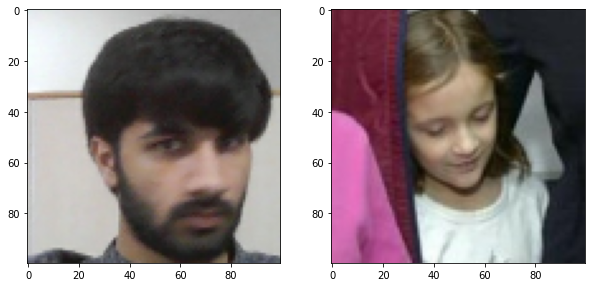

In [52]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[2])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[2])

# Renders cleanly
plt.show()

# 7. Save model

In [53]:
# Save weights
siamese_model.save('siamesemodel.h5')


In [54]:
# Reload model 
model = tf.keras.models.load_model('siamesemodel.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [55]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

1/1 [==============================] - 0s 19ms/step


array([[1.0000000e+00],
       [1.2864042e-10],
       [2.4001451e-07],
       [3.4777587e-14],
       [1.0879462e-07],
       [9.9971086e-01],
       [3.9091633e-11],
       [3.2832200e-13],
       [1.6395918e-12],
       [9.9999917e-01],
       [9.9998307e-01],
       [9.9999785e-01],
       [3.6101608e-07]], dtype=float32)

In [56]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_image (InputLayer)  [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_image[0][0]',            
                                                                  'validation_image[0

# 8. Real-time testing

### Verification function

In [57]:
"""
    Access webcam and grab input image and verify the image in a number of positive samples
"""

'\n    Access webcam and grab input image and verify the image in a number of positive samples\n'

### Verification Function

In [58]:
def verify(frame, model, detection_threshold, verifcation_threshold):
    
    """
        detection_threshold means the value above which a prediction is considered positive
        verification_threshold is proportion of positive predictions by total positive samples
    """
        
    # Build results array
    results = []
    
    
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [59]:
cap = cv2.VideoCapture(0)

while cap.isOpened():
    
    ret, frame = cap.read()
    
    cv2.imshow('Verification', frame)
    
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()

# Refer this article to get better understanding of Siamese Network

### <https://towardsdatascience.com/siamese-networks-introduction-and-implementation-2140e3443dee>